
# Environment Setup & EDA **
This notebook **mounts Google Drive**, finds  **4-class image folder**, and runs:
- Environment/GPU check
- Class counts
- Corrupt-file scan
- Random image grid
- Image size histograms + scatter
- PyTorch `ImageFolder` + `DataLoader` smoke test




In [13]:

#  Environment & GPU check
import os, sys, random, math
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Python: 3.12.12
PyTorch: 2.8.0+cu126
TorchVision: 0.23.0+cu126
CUDA available: True
GPU name: Tesla T4


device(type='cuda')

In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
MYDRIVE = Path('/content/drive/MyDrive')
print("Mounted. Listing top-level of MyDrive:")
print([p.name for p in MYDRIVE.iterdir() if p.is_dir()][:20])


Mounted at /content/drive
Mounted. Listing top-level of MyDrive:
['Colab Notebooks', 'Data', 'Training']


In [8]:
from pathlib import Path
from collections import deque

# path here
MANUAL_DATA_DIR = Path('/content/drive/MyDrive/Training')

# Keeping a simple fallback list
CANDIDATE_PATHS = [
    Path('/content/drive/MyDrive/Training'),
]

IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
EXPECTED_CLASSES_HINT = {'glioma','meningioma','pituitary','notumor'}


Using DATA_DIR: /content/drive/MyDrive/Training
Found candidate class folders: ['glioma', 'meningioma', 'notumor', 'pituitary']


,class,num_images
0,glioma,1330
1,meningioma,1339
2,notumor,1595
3,pituitary,1457


Total images: 5721


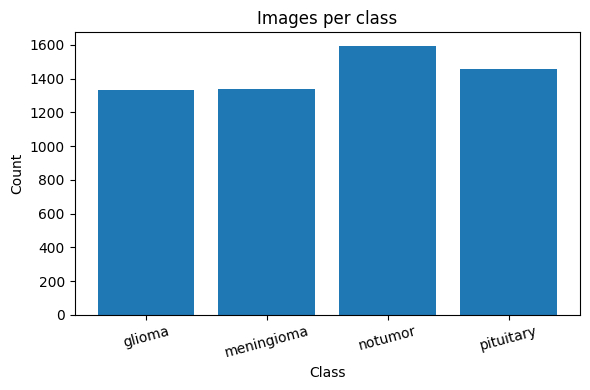

In [7]:
# One-and-done: setting DATA_DIR and verify 4-class structure + counts
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Mount Drive if not already mounted
DRIVE_ROOT = Path('/content/drive')
if not (DRIVE_ROOT / 'MyDrive').exists():
    from google.colab import drive
    drive.mount('/content/drive')

# 🔧 Your dataset path (case-sensitive)
DATA_DIR = Path('/content/drive/MyDrive/Training')  # change if your folder is elsewhere
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR}"

# Recognized image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}

def has_images(d: Path) -> bool:
    """True if directory contains at least one image (recursively)."""
    try:
        for f in d.rglob('*'):
            if f.is_file() and f.suffix.lower() in image_extensions:
                return True
        return False
    except Exception:
        return False

# Keep only subfolders that actually contain images
all_dirs = [p for p in DATA_DIR.iterdir() if p.is_dir()]
class_dirs = [p for p in all_dirs if has_images(p)]
class_names = sorted(p.name for p in class_dirs)

print("Using DATA_DIR:", DATA_DIR)
print("Found candidate class folders:", class_names)
assert len(class_names) == 4, f"Expected 4 class folders with images, found {len(class_names)}: {class_names}"

# Count images per class
rows = []
for p in class_dirs:
    imgs = [f for f in p.rglob('*') if f.is_file() and f.suffix.lower() in image_extensions]
    rows.append({"class": p.name, "num_images": len(imgs)})

counts_df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(counts_df)

total_images = int(counts_df["num_images"].sum())
print(f"Total images: {total_images}")
assert total_images > 0, "No images found. Check your DATA_DIR and subfolders."

# Quick bar plot for visible output
plt.figure(figsize=(6,4))
plt.bar(counts_df["class"], counts_df["num_images"])
plt.title("Images per class")
plt.xlabel("Class"); plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [9]:

#  Integrity scanning for corrupt images (sample-limited)
scan_limit = 5000
scanned = 0
for cname in class_names:
    cpath = Path(DATA_DIR) / cname
    for p in cpath.rglob('*'):
        if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.tiff','.gif'}:
            try:
                with Image.open(p) as im:
                    im.verify()
            except (UnidentifiedImageError, OSError):
                bad_files.append(str(p))
            scanned += 1
            if scanned >= scan_limit:
                break
    if scanned >= scan_limit:
        break

print(f"Scanned up to {scanned} files, corrupt: {len(bad_files)}")
if bad_files:
    print("First 10 problematic files:")
    for bf in bad_files[:10]:
        print("  -", bf)
else:
    print("No corrupt files detected in scan range ✅")


Scanned up to 5000 files, corrupt: 0
No corrupt files detected in scan range ✅


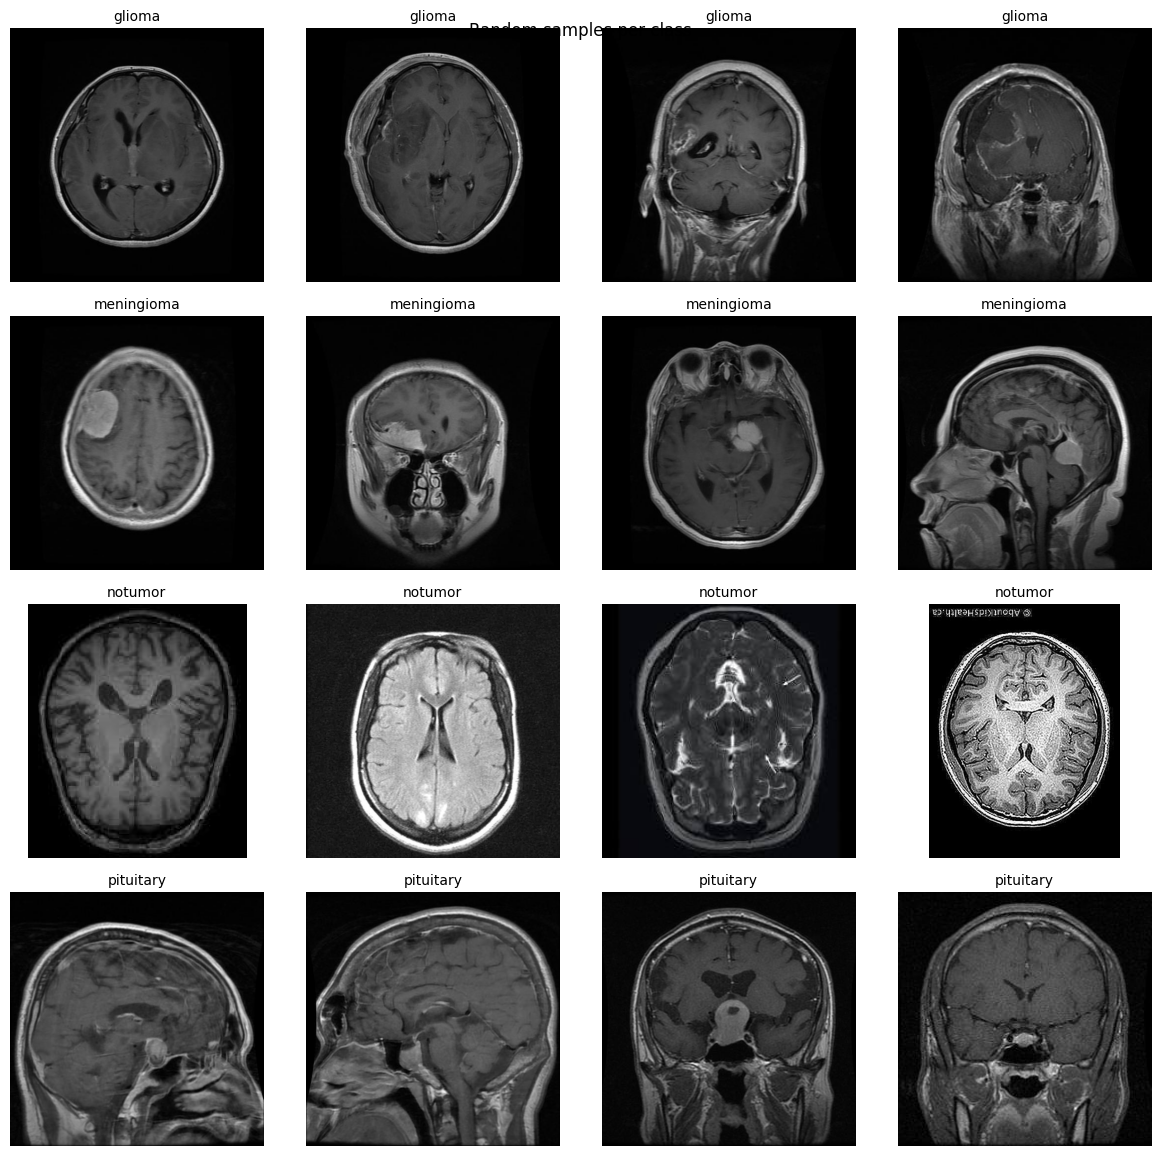

In [10]:

#  Random image grid
import math, random
def sample_images_per_class(root: Path, class_names, k_per_class=4):
    samples = []
    for cname in class_names:
        cpath = Path(root) / cname
        imgs = [p for p in cpath.rglob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.tiff','.gif'}]
        random.shuffle(imgs)
        samples.extend([(cname, p) for p in imgs[:k_per_class]])
    return samples

samples = sample_images_per_class(DATA_DIR, class_names, k_per_class=4)
n = len(samples)
cols = 4
rows = math.ceil(n/cols)
plt.figure(figsize=(cols*3, rows*3))
for i, (cname, p) in enumerate(samples):
    plt.subplot(rows, cols, i+1)
    try:
        img = Image.open(p).convert("RGB")
        plt.imshow(img)
        plt.title(cname, fontsize=10)
        plt.axis('off')
    except Exception as e:
        plt.text(0.5, 0.5, f"Error:\n{e}", ha='center', va='center')
        plt.axis('off')
plt.suptitle("Random samples per class", y=0.95)
plt.tight_layout()
plt.show()


Measured sizes for 1000 images
Mean WxH: 512 x 512
Median WxH: 512 x 512
Unique WxH combos (sampled): 1


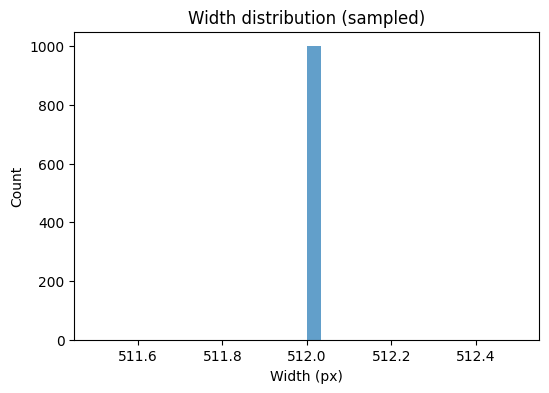

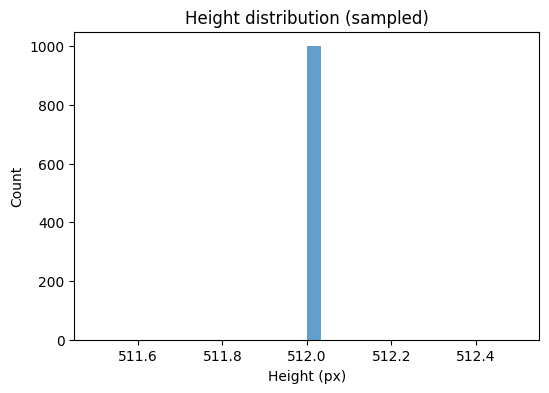

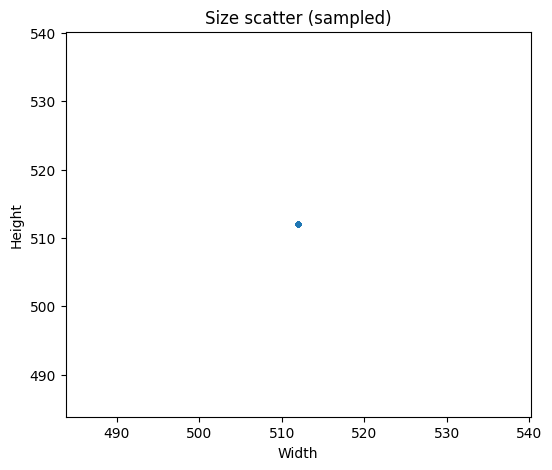

In [11]:

#  Image size distribution (sample up to N images)
N = 1000
sizes = []
picked = 0
for cname in class_names:
    cpath = Path(DATA_DIR) / cname
    imgs = [p for p in cpath.rglob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png','.bmp','.tiff','.gif'}]
    random.shuffle(imgs)
    for p in imgs:
        try:
            with Image.open(p) as im:
                w, h = im.size
                sizes.append((w, h, cname))
                picked += 1
                if picked >= N:
                    break
        except Exception:
            pass
    if picked >= N:
        break

sizes = np.array(sizes, dtype=object)
print(f"Measured sizes for {len(sizes)} images")
if len(sizes):
    widths = np.array([int(w) for w in sizes[:,0]])
    heights = np.array([int(h) for h in sizes[:,1]])
    print("Mean WxH:", int(widths.mean()), "x", int(heights.mean()))
    print("Median WxH:", int(np.median(widths)), "x", int(np.median(heights)))
    print("Unique WxH combos (sampled):", len(set(zip(widths, heights))))

    plt.figure(figsize=(6,4))
    plt.hist(widths, bins=30, alpha=0.7)
    plt.xlabel("Width (px)"); plt.ylabel("Count"); plt.title("Width distribution (sampled)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(heights, bins=30, alpha=0.7)
    plt.xlabel("Height (px)"); plt.ylabel("Count"); plt.title("Height distribution (sampled)")
    plt.show()

    plt.figure(figsize=(6,5))
    plt.scatter(widths, heights, s=8, alpha=0.6)
    plt.xlabel("Width"); plt.ylabel("Height"); plt.title("Size scatter (sampled)")
    plt.show()
else:
    print("No sizes measured; check your dataset path or file formats.")


Classes detected by ImageFolder: ['glioma', 'meningioma', 'notumor', 'pituitary']
Batch tensor shape: torch.Size([16, 3, 256, 256])
Labels shape: torch.Size([16])
Device before move: cpu
Moved mini-batch to: cuda:0


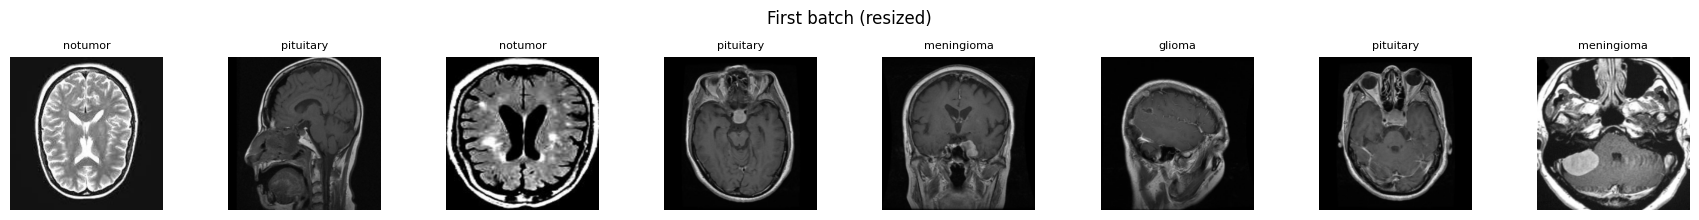

In [12]:

#  Building ImageFolder dataset & simple DataLoader smoke test
IMG_SIZE = 256
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=str(DATA_DIR), transform=transform)
print("Classes detected by ImageFolder:", dataset.classes)
assert len(dataset.classes) == 4, "ImageFolder did not find exactly 4 classes."

loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

images, labels = next(iter(loader))
print("Batch tensor shape:", images.shape)  # [B,C,H,W]
print("Labels shape:", labels.shape)
print("Device before move:", images.device)

images_gpu = images.to(device)[:4]
labels_gpu = labels.to(device)[:4]
print("Moved mini-batch to:", images_gpu.device)

# Visualizing a few
grid_count = min(8, images.shape[0])
fig, axs = plt.subplots(1, grid_count, figsize=(grid_count*2.2, 2.2))
for i in range(grid_count):
    ax = axs[i] if grid_count > 1 else axs
    npimg = images[i].permute(1,2,0).numpy()
    ax.imshow(np.clip(npimg, 0, 1))
    ax.axis('off')
    ax.set_title(dataset.classes[labels[i].item()], fontsize=8)
plt.suptitle("First batch (resized)")
plt.tight_layout()
plt.show()


In [14]:

print("Drive-only setup complete. Environment OK, dataset loaded from Drive, and EDA visuals rendered.")


Drive-only setup complete. Environment OK, dataset loaded from Drive, and EDA visuals rendered.
